<a href="https://colab.research.google.com/github/smitasahu2/Teaching-UoP/blob/main/Exercisesheet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalation of few package you might not need that

In [ ]:
!pip install tabulate
%pip install pybamm -q    # install PyBaMM if it is not installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.6/22.6 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.7 MB/s eta 0:00:00


# Additing all the necesarry packages

In [ ]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tabulate import tabulate
import sympy as sp

In [ ]:
from google.colab import drive #We first "mount" the google drive
drive.mount('/content/drive')
import pandas as pd   #Set path to where you placed the data
from pathlib import Path

Mounted at /content/drive


In [ ]:
# Access the CSV file
Experiment_data = '/content/drive/MyDrive/ecm/data/ecm_example_ocv.csv'
# Read CSV file
df = pd.read_csv(Experiment_data)
# Explore data
print(df.head())
print(df.info())

   # SoC   OCV [V]
0  -0.05  2.555445
1  -0.04  2.696589
2  -0.03  2.835424
3  -0.02  2.968882
4  -0.01  3.092235
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   # SoC    110 non-null    float64
 1   OCV [V]  110 non-null    float64
dtypes: float64(2)
memory usage: 1.8 KB
None


In [ ]:
SOC_Experiment = df['# SoC']
OCV_Experiment = df['OCV [V]']

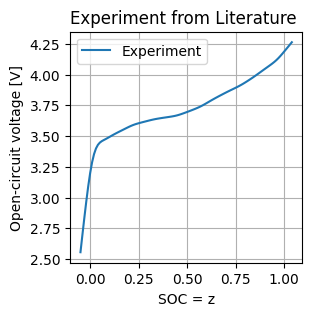

In [ ]:
plt.figure(figsize=(3, 3))
plt.plot(SOC_Experiment, OCV_Experiment, label='Experiment')
plt.xlabel('SOC = z')
plt.ylabel('Open-circuit voltage [V]')
plt.title('Experiment from Literature ')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
interp_func = interp1d(SOC_Experiment, OCV_Experiment, kind='linear')
def fitted_OCV(soc_value):
    return interp_func(soc_value)

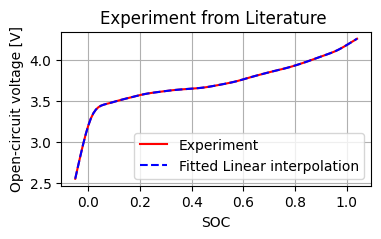

In [ ]:
plt.figure(figsize=(4, 2))
plt.plot(SOC_Experiment, OCV_Experiment,'-r',label='Experiment')
plt.plot(SOC_Experiment, fitted_OCV(SOC_Experiment), '--b',label='Fitted Linear interpolation')
plt.xlabel('SOC')
plt.ylabel('Open-circuit voltage [V]')
plt.title('Experiment from Literature ')
plt.legend()
plt.grid(True)
plt.show()

#Symbolic Calculation for the exact solution

In [ ]:
t, Q, I, eta = sp.symbols('t Q I, eta')
z = sp.Function('z')(t)

# Define the time-dependent current function I(t)
def I_of_(t):
    return -50

ode = sp.Eq(z.diff(t), (-eta * I_of_(t)) / Q/3600)
initial_condition = {z.subs(t, 0): 0}
solution = sp.dsolve(ode, z, ics=initial_condition)
z_func = sp.lambdify((t, eta, Q), solution.rhs, 'numpy')

# # Example parameters
Q = 100
z0 = 0
eta = 1.0
dt = 0.1
T_end = 1.0
# Define the data as a list of tuples
parameters = [
    ("Capacity (As)", Q),
    ("Initial SOC", z0),
    ("Coulombic Efficiency", eta),
    ("time Step", dt),
    ("Final time", T_end),

]
print(tabulate(parameters, headers=["Parameter", "Value"]))
# Run Euler method
# Define symbols
# def I_of_(t):
#     return 100 * np.tanh(t)  # Modify this function to accept a single value

def euler_method(I_func, Q, z0, eta, dt, T_end):
    num_steps = int(T_end / dt)
    time = np.linspace(0, T_end, num_steps + 1)
    z_values = np.zeros(num_steps + 1)
    z_values[0] = z0
    for i in range(num_steps):
        z_values[i + 1] = z_values[i] - eta * (I_func(time[i]) / Q/3600) * dt
    return time, z_values

# Example parameters
Q = 100.0
z0 = 0
eta = 1.0
dt = 0.1
T_end = 1800.0

# Define the data as a list of tuples
parameters = [
    ("Capacity (As)", Q),
    ("Initial SOC", z0),
    ("Coulombic Efficiency", eta),
    ("time Step", dt),
    ("Final time", T_end),

]
print(tabulate(parameters, headers=["Parameter", "Value"]))
# Run Euler method
t_values, z_values = euler_method(I_of_, Q, z0, eta, dt, T_end)
z_exact = z_func(t_values,eta,Q)

Parameter               Value
--------------------  -------
Capacity (As)           100
Initial SOC               0
Coulombic Efficiency      1
time Step                 0.1
Final time                1
Parameter               Value
--------------------  -------
Capacity (As)           100
Initial SOC               0
Coulombic Efficiency      1
time Step                 0.1
Final time             1800


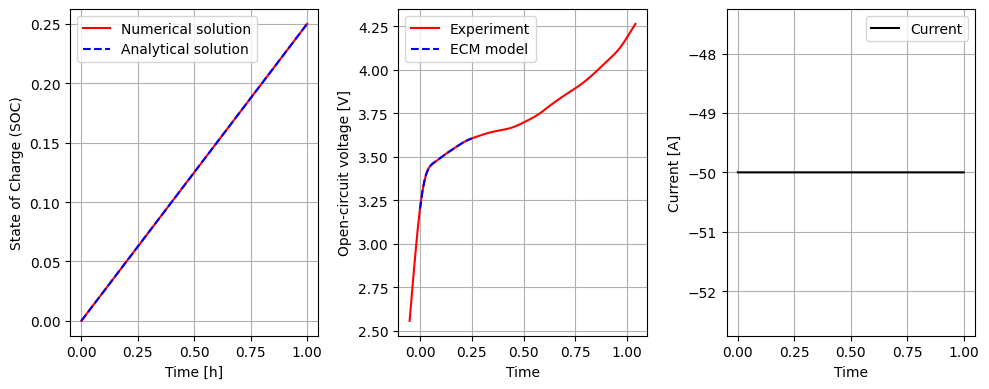

In [ ]:
# Plot voltage and current on separate subplots
fig, axs = plt.subplots(1, 3, figsize=(10,4))

# Plot 1: Time vs SOC
axs[0].plot(t_values/max(t_values), z_values, '-r', label='Numerical solution')
axs[0].plot(t_values/max(t_values), z_exact, '--b', label='Analytical solution')
axs[0].set_xlabel('Time [h]')
axs[0].set_ylabel('State of Charge (SOC)')
axs[0].legend()
axs[0].grid()

# Plot 2: Time vs OCV
axs[1].plot(SOC_Experiment, OCV_Experiment, '-r', label='Experiment')
axs[1].plot(z_values, fitted_OCV(z_values), '--b', label='ECM model')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Open-circuit voltage [V]')
axs[1].legend()
axs[1].grid()

# Plot 3: Time vs Current
axs[2].plot(t_values/max(t_values),  np.ones_like(t_values)*I_of_(t_values/max(t_values)), '-k', label='Current')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Current [A]')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()


Charge discharge

In [ ]:
t, Q, I, eta = sp.symbols('t Q I, eta')
z = sp.Function('z')(t)

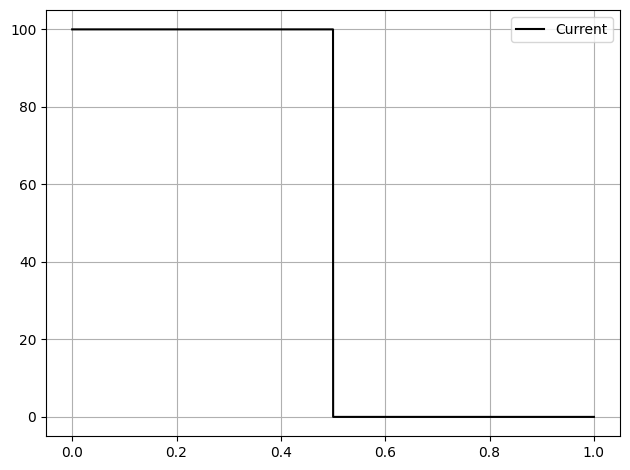

In [ ]:
def I_of_(t):
  current = np.zeros_like(t)
  current[t < 0.5] = 100  # First half hour
  current[(t >= 0.5) & (t < 0.65)] = 0  # 15 minutes of zero current
  current[t >= 65] = -100  # Second half hour
  return current


plt.plot(t_values/max(t_values),  np.ones_like(t_values)*I_of_(t_values/max(t_values)), '-k', label='Current')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

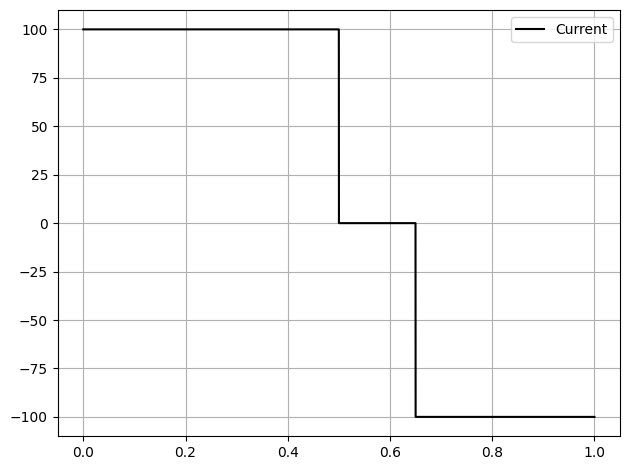

TypeError: len() of unsized object

In [ ]:
def I_of_(t):
    t = np.asarray(t)  # Convert t to a numpy array if it's not already one
    current = np.zeros_like(t)
    num_steps = len(current)
    time_indices = (t * num_steps).astype(int)  # Convert time to array indices
    current[time_indices < int(0.5 * num_steps)] = 100  # First half hour
    current[(time_indices >= int(0.5 * num_steps)) & (time_indices < int(0.65 * num_steps))] = 0  # 15 minutes of zero current
    current[time_indices >= int(0.65 * num_steps)] = -100  # Second half hour
    return current




def I_of_(t):
    current = np.zeros_like(t)
    num_steps = len(current)
    time_indices = (t * num_steps).astype(int)  # Convert time to array indices
    current[time_indices < int(0.5 * num_steps)] = 100  # First half hour
    current[(time_indices >= int(0.5 * num_steps)) & (time_indices < int(0.65 * num_steps))] = 0  # 15 minutes of zero current
    current[time_indices >= int(0.65 * num_steps)] = -100  # Second half hour
    return current




plt.plot(t_values/max(t_values),  np.ones_like(t_values)*I_of_(t_values/max(t_values)), '-k', label='Current')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


ode = sp.Eq(z.diff(t), (eta * I_of_(t)) / Q/3600)
initial_condition = {z.subs(t, 0): 0.0}
solution = sp.dsolve(ode, z, ics=initial_condition)
z_func = sp.lambdify((t, eta, Q), solution.rhs, 'numpy')

# # Example parameters
Q = 100
z0 = 0.0
eta = 1.0
dt = 0.1
T_end = 1.0
# Define the data as a list of tuples
parameters = [
    ("Capacity (As)", Q),
    ("Initial SOC", z0),
    ("Coulombic Efficiency", eta),
    ("time Step", dt),
    ("Final time", T_end),

]
print(tabulate(parameters, headers=["Parameter", "Value"]))
# Run Euler method
# Define symbols
# def I_of_(t):
#     return 100 * np.tanh(t)  # Modify this function to accept a single value

def euler_method(I_func, Q, z0, eta, dt, T_end):
    num_steps = int(T_end / dt)
    time = np.linspace(0, T_end, num_steps + 1)
    z_values = np.zeros(num_steps + 1)
    z_values[0] = z0
    for i in range(num_steps):
        z_values[i + 1] = z_values[i] + eta * (I_func(time[i]) / Q/3600) * dt
    return time, z_values

# Example parameters
Q = 100.0
z0 = 0.0
eta = 1.0
dt = 0.1
T_end = 3600.0

# Run Euler method
t_values, z_values = euler_method(I_of_, Q, z0, eta, dt, T_end)
z_exact = z_func(t_values,eta,Q)

In [ ]:
def I_of_(t):
    t = np.asarray(t)  # Convert t to a numpy array if it's not already one
    if isinstance(t, np.ndarray):
        current = np.zeros_like(t)
        num_steps = t.size
    else:
        current = np.zeros(1)
        num_steps = 1

    time_indices = (t * num_steps).astype(int)  # Convert time to array indices
    current[time_indices < int(0.5 * num_steps)] = 100  # First half hour
    current[time_indices >= int(0.5 * num_steps)] = -100  # Second half hour
    return current

# # Example parameters
Q = 100
z0 = 0.0
eta = 1.0
dt = 0.1
T_end = 1.0
# Define the data as a list of tuples
parameters = [
    ("Capacity (As)", Q),
    ("Initial SOC", z0),
    ("Coulombic Efficiency", eta),
    ("time Step", dt),
    ("Final time", T_end),

]
#print(tabulate(parameters, headers=["Parameter", "Value"]))
# Run Euler method
# Define symbols
# def I_of_(t):
#     return 100 * np.tanh(t)  # Modify this function to accept a single value

def euler_method(I_func, Q, z0, eta, dt, T_end):
    num_steps = int(T_end / dt)
    time = np.linspace(0, T_end, num_steps + 1)
    z_values = np.zeros(num_steps + 1)
    z_values[0] = z0
    for i in range(num_steps):
        z_values[i + 1] = z_values[i] + eta * (I_func(time[i]) / Q/3600) * dt
    return time, z_values

# Example parameters
Q = 100.0
z0 = 0.0
eta = 1.0
dt = 0.1
T_end = 7200.0

# Run Euler method
t_values, z_values = euler_method(I_of_, Q, z0, eta, dt, T_end)
z_exact = z_func(t_values,eta,Q)

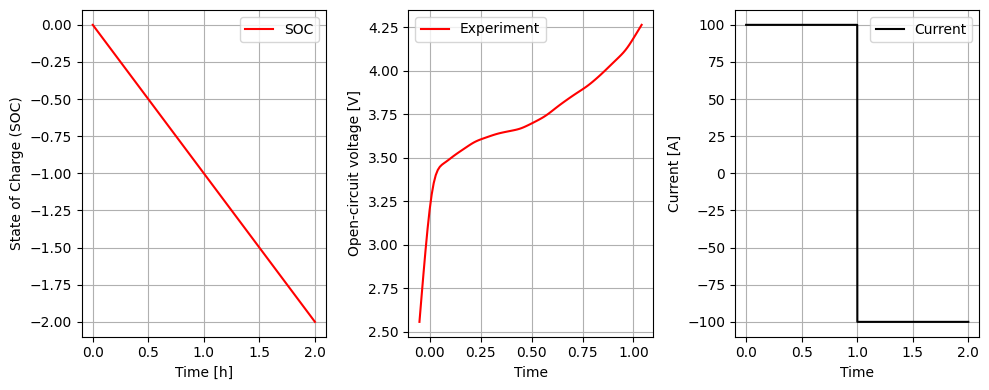

In [ ]:
# Plot voltage and current on separate subplots
fig, axs = plt.subplots(1, 3, figsize=(10,4))

# Plot 1: Time vs SOC
axs[0].plot(t_values/3600, z_values, '-r', label='SOC')
axs[0].set_xlabel('Time [h]')
axs[0].set_ylabel('State of Charge (SOC)')
axs[0].legend()
axs[0].grid()

# Plot 2: Time vs OCV
axs[1].plot(SOC_Experiment, OCV_Experiment, '-r', label='Experiment')
#axs[1].plot(z_values, fitted_OCV(z_values), '--b', label='ECM model')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Open-circuit voltage [V]')
axs[1].legend()
axs[1].grid()

# Plot 3: Time vs Current
axs[2].plot(t_values/3600, I_of_(t_values/max(t_values)), '-k', label='Current')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Current [A]')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()


In [ ]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import os
import numpy as np
import matplotlib.pyplot as plt
#os.chdir(pybamm.__path__[0]+'/..')

To display the table in LaTeX format with the values included in a Google Colab Markdown cell, you can't directly render LaTeX code, but you can include it as text. Here's the LaTeX code with the values included:

#List of the parameters we need for the one RC pair Thevenin model
\begin{array}{|l|l|l|}
\hline
\text{Name} & \text{Description} & \text{Unit} \\
\hline
\text{Chemistry} & \text{Electrolyte chemistry} & - \\
\text{Initial SoC} & \text{Initial state of charge} & - \\
\text{Initial temperature [K]} & \text{Initial temperature in Kelvin} & K \\
\text{Cell capacity [A.h]} & \text{Capacity of the cell} & A.h \\
\text{Nominal cell capacity [A.h]} & \text{Nominal capacity of the cell} & A.h \\
\text{Ambient temperature [K]} & \text{Ambient temperature in Kelvin} & K \\
\text{Current function [A]} & \text{Current flowing through the cell} & A \\
\text{Upper voltage cut-off [V]} & \text{Upper limit for cell voltage} & V \\
\text{Lower voltage cut-off [V]} & \text{Lower limit for cell voltage} & V \\
\text{Cell thermal mass [J/K]} & \text{Thermal mass of the cell} & J/K \\
\text{Cell-jig heat transfer coefficient [W/K]} & \text{Heat transfer coefficient between cell and jig} & W/K \\
\text{Jig thermal mass [J/K]} & \text{Thermal mass of the jig} & J/K \\
\text{Jig-air heat transfer coefficient [W/K]} & \text{Heat transfer coefficient between jig and air} & W/K \\
\text{Open-circuit voltage [V]} & \text{Voltage of the cell at open circuit} & V \\
R0 [\Omega] & \text{Resistance parameter 0} & \Omega \\
\text{Element-1 initial overpotential [V]} & \text{Initial overpotential of element 1} & V \\
R1 [\Omega] & \text{Resistance parameter 1} & \Omega \\
C1 [F] & \text{Capacitance parameter 1} & F \\
\text{Entropic change [V/K]} & \text{Entropic change with respect to temperature} & V/K \\
\text{RCR lookup limit [A]} & \text{Lookup limit for RCR curve} & A \\
\hline
\end{array}



Copy and paste this code into a Markdown cell in your Google Colab notebook. The Markdown renderer in Colab will render it as text, displaying the LaTeX code along with the table structure and the parameter values.

interactive(children=(FloatSlider(value=0.0, description='t', max=14.842406925501857, step=0.14842406925501858…

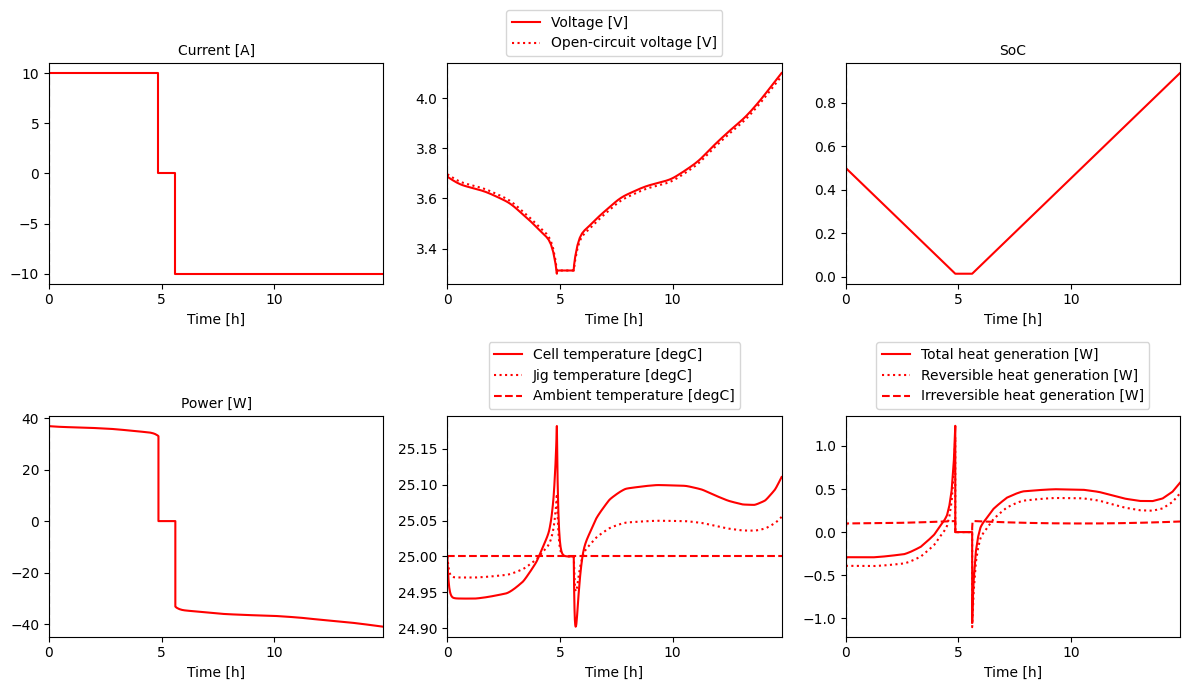

In [ ]:
import pybamm

#pybamm.set_logging_level("INFO")

model = pybamm.equivalent_circuit.Thevenin()

experiment = pybamm.Experiment(
    [
        (
            "Discharge at C/10 until 3.3 V",
            "Rest for 45 minutes",
            "Charge at C/10 until 4.1 V",
            # "Hold at 4.1 V until 5 A",
            # "Rest for 30 minutes",
            # "Rest for 1 hour",
        ),
    ]
)


# experiment = pybamm.Experiment(
#     [
#         (
#             "Discharge at C/10 for 10 hours or until 3.3 V",
#             "Rest for 30 minutes",
#             "Rest for 2 hours",
#             "Charge at 100 A until 4.1 V",
#             # "Hold at 4.1 V until 5 A",
#             # "Rest for 30 minutes",
#             # "Rest for 1 hour",
#         ),
#     ]
# )

sim = pybamm.Simulation(model, experiment=experiment)
sim.solve()
sim.plot()

In [ ]:

import pybamm
import os

# An example set of parameters for the equivalent circuit model

path, _ = os.path.split(os.path.abspath(__file__))

ocv_data = pybamm.parameters.process_1D_data("ecm_example_ocv.csv", path=path)

r0_data = pybamm.parameters.process_3D_data_csv("ecm_example_r0.csv", path=path)
r1_data = pybamm.parameters.process_3D_data_csv("ecm_example_r1.csv", path=path)
c1_data = pybamm.parameters.process_3D_data_csv("ecm_example_c1.csv", path=path)

dUdT_data = pybamm.parameters.process_2D_data_csv("ecm_example_dudt.csv", path=path)


def ocv(sto):
    name, (x, y) = ocv_data
    return pybamm.Interpolant(x, y, sto, name)


def r0(T_cell, current, soc):
    name, (x, y) = r0_data
    return pybamm.Interpolant(x, y, [T_cell, current, soc], name)


def r1(T_cell, current, soc):
    name, (x, y) = r1_data
    return pybamm.Interpolant(x, y, [T_cell, current, soc], name)


def c1(T_cell, current, soc):
    name, (x, y) = c1_data
    return pybamm.Interpolant(x, y, [T_cell, current, soc], name)


def dUdT(ocv, T_cell):
    name, (x, y) = dUdT_data
    return pybamm.Interpolant(x, y, [ocv, T_cell], name)


def get_parameter_values():
    """
    Example parameter set for a equivalent circuit model with a
    resistor in series with a single RC element.

    This parameter set is for demonstration purposes only and
    does not reflect the properties of any particular cell.
    Example functional dependancies have been added for each of
    the parameters to demonstrate the functionality of
    3D look-up tables models. Where parameters have been taken
    from the literature, we do not disclose the source
    in order to avoid confusion that these values represent
    any particular cell.

    The parameter values have been generated in the following
    manner:

        1. Capacity assumed to be 100Ah
        2. 100A DCIR at T25 S50 assumed to be 1mOhm
        3. DCIR assume to be have the following dependencies:
            - quadratic in SoC (increasing to 1.2mOhm
              at 0% and 100% SoC)
            - Arrhenius in temperature (with Ea=20000)
            - linear with the magnitude of the current (with
                slope 0.01 mohms per 100 amps)
        4. R0 taken to be 40% of the DCIR
        5. R1 taken to be 60% of the DCIR
        6. C1 is derived from the C1 = tau / R1 where tau=30s
        7. OCV is taken from an undisclosed literature source.
        8. dUdT is taken from an undisclosed literature source.

    """

    # N.B. actual cell capacity and nominal cell capcity
    # can be different hence the two parameters
    cell_capacity = 100

    values = {
        "chemistry": "ecm",
        "Initial SoC": 0.5,
        "Initial temperature [K]": 25 + 273.15,
        "Cell capacity [A.h]": cell_capacity,
        "Nominal cell capacity [A.h]": cell_capacity,
        "Ambient temperature [K]": 25 + 273.15,
        "Current function [A]": 100,
        "Upper voltage cut-off [V]": 4.2,
        "Lower voltage cut-off [V]": 3.2,
        "Cell thermal mass [J/K]": 1000,
        "Cell-jig heat transfer coefficient [W/K]": 10,
        "Jig thermal mass [J/K]": 500,
        "Jig-air heat transfer coefficient [W/K]": 10,
        "Open-circuit voltage [V]": ocv,
        "R0 [Ohm]": r0,
        "Element-1 initial overpotential [V]": 0,
        "R1 [Ohm]": r1,
        "C1 [F]": c1,
        "Entropic change [V/K]": dUdT,
        "RCR lookup limit [A]": 340,
    }

    return values


NameError: name '__file__' is not defined

2024-04-18 10:51:33.266 - [NOTICE] callbacks.on_cycle_start(172): Cycle 1/20 (136.094 us elapsed) --------------------
NOTICE:pybamm.logger:Cycle 1/20 (136.094 us elapsed) --------------------
2024-04-18 10:51:33.283 - [NOTICE] callbacks.on_step_start(180): Cycle 1/20, step 1/1: Discharge at 1C for 2 minutes (1 second period)
NOTICE:pybamm.logger:Cycle 1/20, step 1/1: Discharge at 1C for 2 minutes (1 second period)
2024-04-18 10:51:38.967 - [NOTICE] callbacks.on_cycle_start(172): Cycle 2/20 (5.702 s elapsed) --------------------
NOTICE:pybamm.logger:Cycle 2/20 (5.702 s elapsed) --------------------
2024-04-18 10:51:38.986 - [NOTICE] callbacks.on_step_start(180): Cycle 2/20, step 1/1: Rest for 20 minutes (1 second period)
NOTICE:pybamm.logger:Cycle 2/20, step 1/1: Rest for 20 minutes (1 second period)
2024-04-18 10:51:46.541 - [NOTICE] callbacks.on_cycle_start(172): Cycle 3/20 (13.276 s elapsed) --------------------
NOTICE:pybamm.logger:Cycle 3/20 (13.276 s elapsed) --------------------

SoC from x and y should match: True


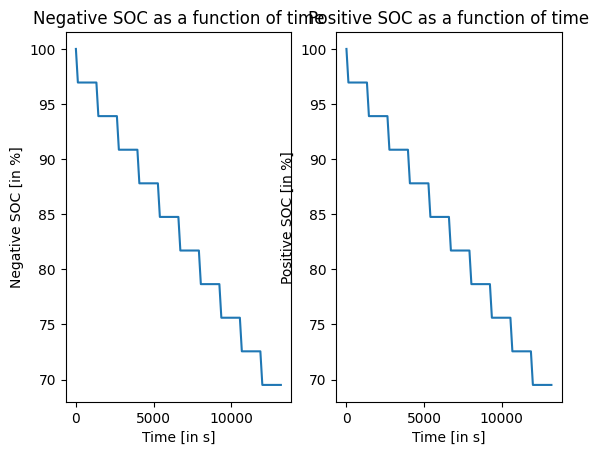

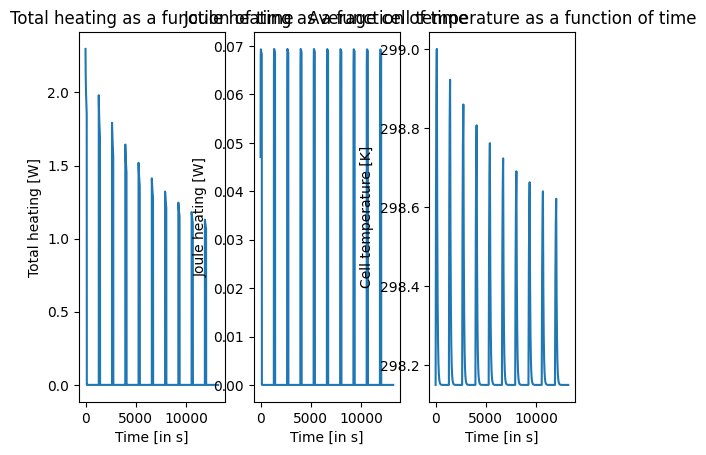

In [ ]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

# Set up model and parameters
options = {"thermal": "lumped"}
DFN_21700 = pybamm.lithium_ion.DFN(options=options)
param = DFN_21700.param
parameters = pybamm.ParameterValues("Mohtat2020")
parameters["Initial concentration in positive electrode [mol.m-3]"] = 38000.0

# Calculate stoichiometries at 100% SOC
x_0, x_100, y_100, y_0 = pybamm.lithium_ion.get_min_max_stoichiometries(
    parameters, param
)

# Update parameter values with initial conditions
c_n_max = parameters["Maximum concentration in negative electrode [mol.m-3]"]
c_p_max = parameters["Maximum concentration in positive electrode [mol.m-3]"]
parameters.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": x_100 * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": y_100 * c_p_max,
    }
)

# Experiment setup
experiment = pybamm.Experiment(
    [
        "Discharge at 1C for 2 minutes (1 second period)",
        "Rest for 20 minutes (1 second period)",
    ]
    * 10
)

# Solving the model
var_pts = {"x_n": 30, "x_s": 30, "x_p": 30, "r_n": 10, "r_p": 10}
pybamm.set_logging_level("NOTICE")
sim_DFN = pybamm.Simulation(
    DFN_21700, experiment=experiment, parameter_values=parameters, var_pts=var_pts
)
sim_DFN.solve()

# Outputs
solution_DFN = sim_DFN.solution
t_DFN = solution_DFN["Time [s]"].entries

x = solution_DFN["Average negative particle concentration"].entries
cell_SoC_x = 100 * (x - x_0) / (x_100 - x_0)

y = solution_DFN["Average positive particle concentration"].entries
cell_SoC_y = 100 * (y - y_0) / (y_100 - y_0)

Total_heating_DFN = solution_DFN["Total heating [W.m-3]"].entries
Ohmic_heating_DFN = solution_DFN["Ohmic heating [W.m-3]"].entries
Cell_Temp_DFN = solution_DFN["Cell temperature [K]"].entries

print("SoC from x and y should match:", np.allclose(cell_SoC_x, cell_SoC_y))

# Plots
fig, axs = plt.subplots(1, 2)

axs[0].plot(t_DFN, cell_SoC_x)
axs[0].set_title("Negative SOC as a function of time")
axs[0].set(xlabel="Time [in s]")
axs[0].set(ylabel="Negative SOC [in %]")

axs[1].plot(t_DFN, cell_SoC_y)
axs[1].set_title("Positive SOC as a function of time")
axs[1].set(xlabel="Time [in s]")
axs[1].set(ylabel="Positive SOC [in %]")

Cell_volume = parameters["Cell volume [m3]"]
Total_heating_DFN = np.average(Total_heating_DFN, axis=0) * Cell_volume
Ohmic_heating_DFN = np.average(Ohmic_heating_DFN, axis=0) * Cell_volume
Cell_Temp_DFN = np.average(Cell_Temp_DFN, axis=0)

fig, axs = plt.subplots(1, 3)
axs[0].plot(t_DFN, Total_heating_DFN)
axs[0].set_title("Total heating as a function of time")
axs[0].set(xlabel="Time [in s]")
axs[0].set(ylabel="Total heating [W]")

axs[1].plot(t_DFN, Ohmic_heating_DFN)
axs[1].set_title("Joule heating as a function of time")
axs[1].set(xlabel="Time [in s]")
axs[1].set(ylabel="Joule heating [W]")

axs[2].plot(t_DFN, Cell_Temp_DFN)
axs[2].set_title("Average cell temperature as a function of time")
axs[2].set(xlabel="Time [in s]")
axs[2].set(ylabel="Cell temperature [K]")
plt.show()